# Failure type classification 

This is a POC notebook for analyzing testgrids and generating a report that will identify the tests and dates where 4 different types of failures may have occurred.   

Goal: Auto label test grids with the following types of failures:

* Infra Flake
* Flaky Tests
* Install Flake 
* New Test Failure

Next Steps/To Do:  
* Create visualized results on one grid
* Aggregate results for the whole platform. 

In [1]:
import json
import gzip
import datetime
import pandas as pd
import numpy as np
from scipy.signal import convolve2d
from IPython.display import Image

import matplotlib.pyplot as plt

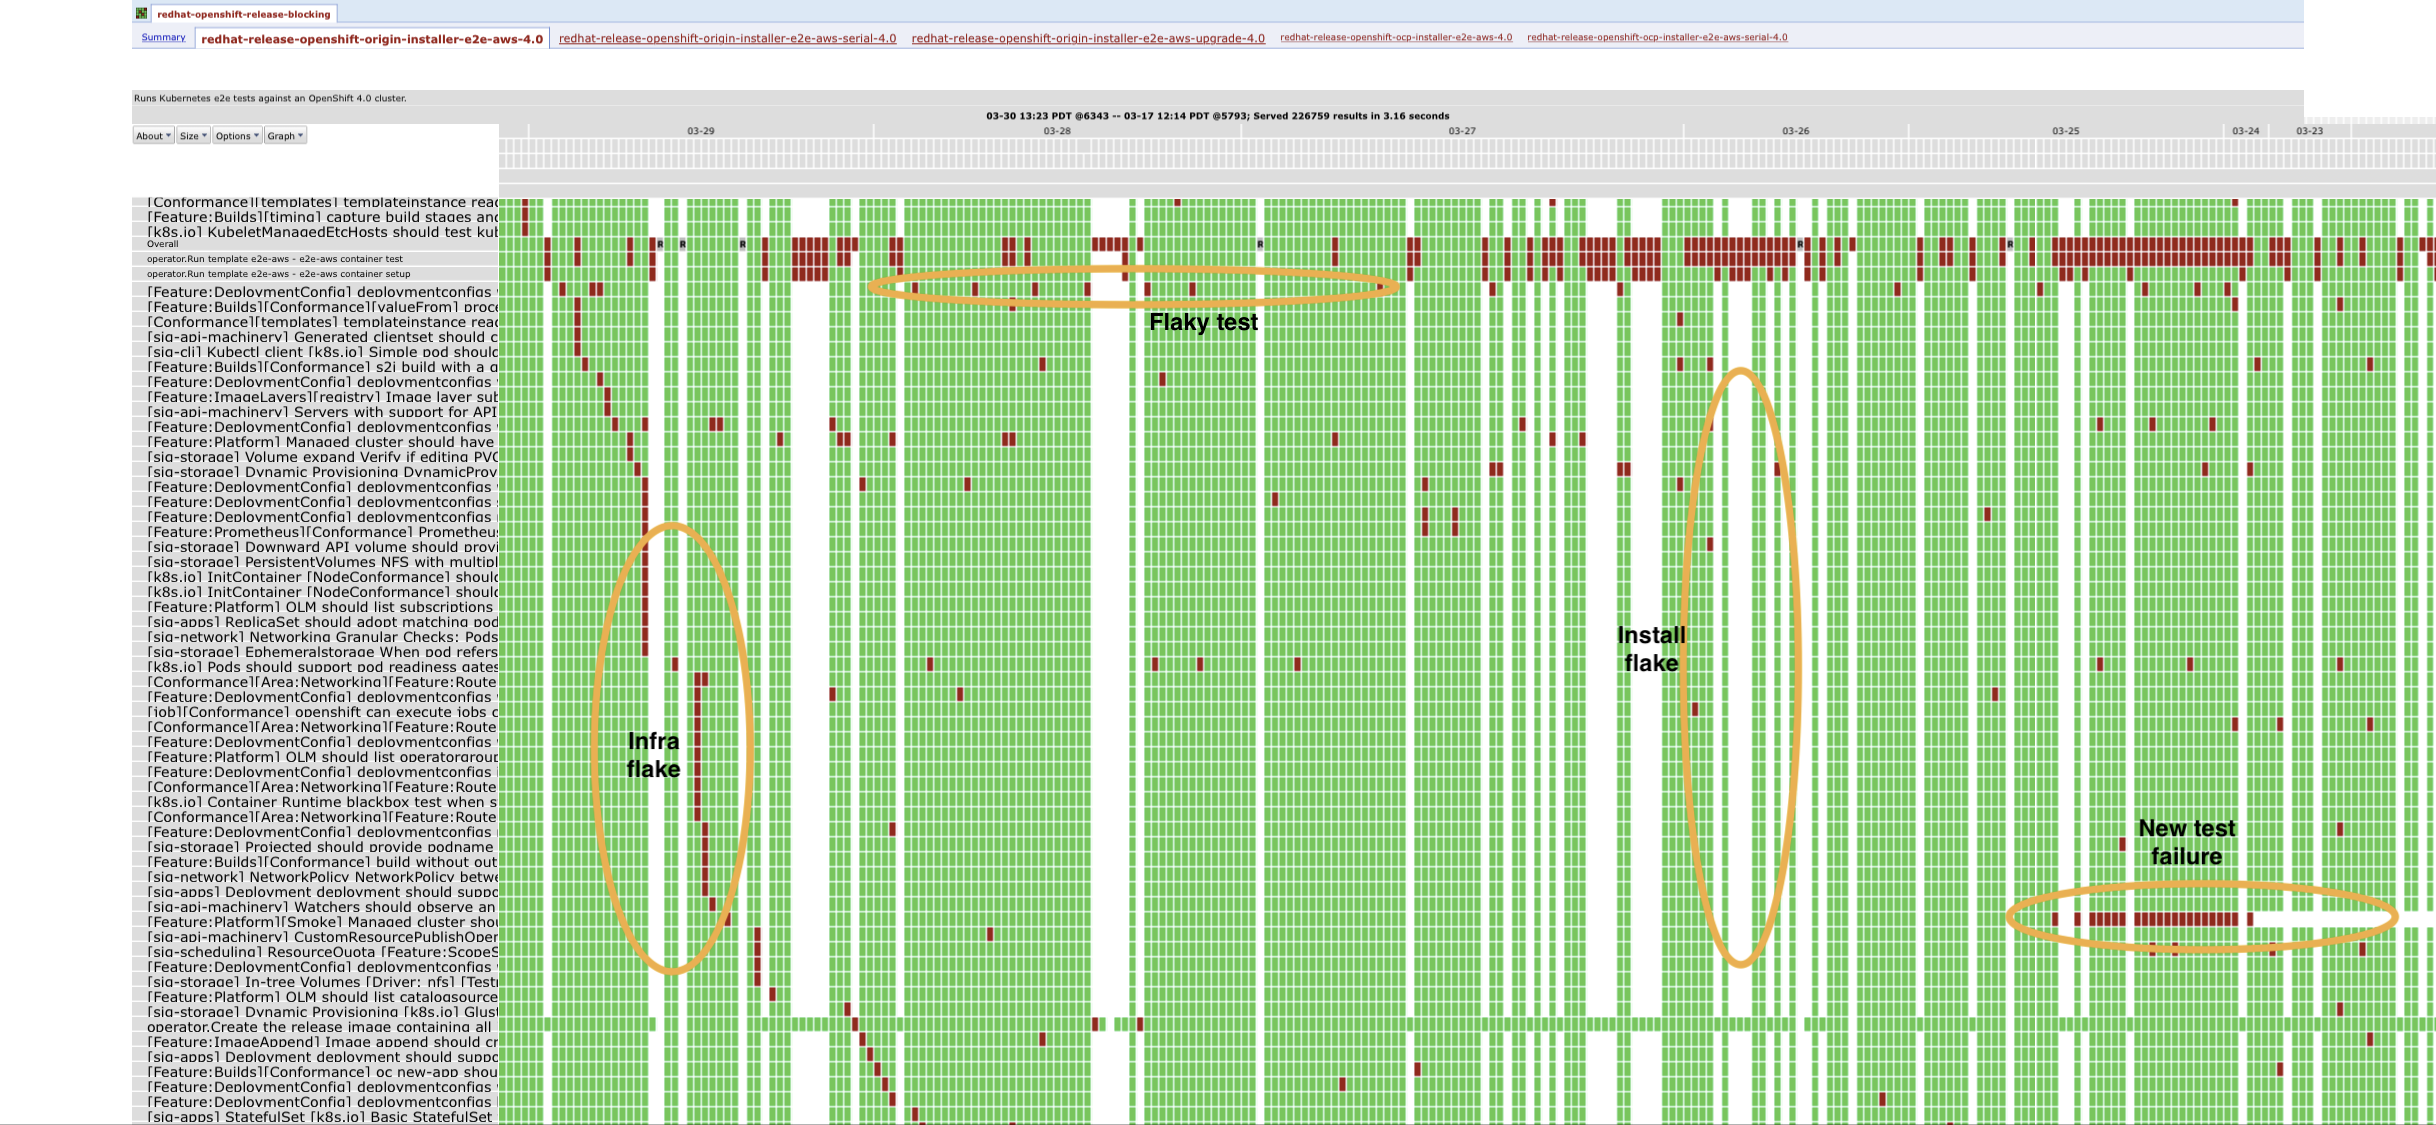

In [2]:
Image(
    "https://user-images.githubusercontent.com/161888/89903201-a62b3800-dbe7-11ea-9b1c-2ec62fe8952f.png"
)

### Hand annotated example

The image above is a hand annotated testgrid. The aim of this notebook is to automate this process. 

In [3]:
# Include necessary function from TestGrid_EDA.ipynb
def decode_run_length(x):
    lst = []
    for run_length in x:
        extension = [run_length["value"]] * run_length["count"]
        lst.extend(extension)
    return lst


def run_length_encode(x):
    """run length encoding """

    rle = []
    count = 1
    for i, j in enumerate(x):
        key = j
        if i == len(x) - 1:
            rle.append((key, count, i))
            break
        if key == x[i + 1]:
            count += 1
        else:
            rle.append((key, count, i))
            count = 1
    return rle

In [4]:
# load sample data
with gzip.open("../data/raw/testgrid_810.json.gz", "rb") as read_file:
    data = json.load(read_file)

In [5]:
grid = data['"redhat-openshift-ocp-release-4.3-informing"'][
    "release-openshift-origin-installer-e2e-gcp-compact-4.3"
]["grid"]

In [6]:
x = np.array(list(pd.DataFrame(grid).statuses.apply(decode_run_length)))

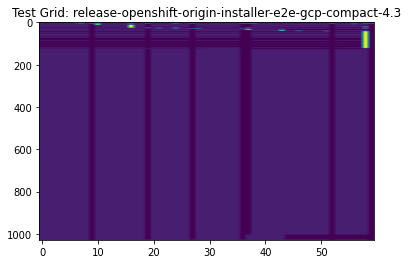

In [7]:
# Display example testgrid
plt.imshow(x, aspect="auto")
plt.title("Test Grid: release-openshift-origin-installer-e2e-gcp-compact-4.3")
plt.show()

In [8]:
# We want to re-map the values so that the output of the convolution will be more interpretable.
def normalize(x):
    if x == 1:
        return 1
    if x == 12:
        return -1
    if x == 0:
        return 0

### Detect Infrastructure Flakes

In [9]:
def detect_infra_flake(grid, tab_name, grid_name):
    """
    This function takes a 2d numpy array "grid" and uses a diagonal edge detecting
    filter to identify time windows in which 'infrastructure flakes' occured.

    Returns a list of dates and test indexes
    """
    infra_flakes_found = []

    # 2d filter that will have its highest value when convolved with a diagonal pattern.
    infra_flake_filter = np.array([[-1, 1], [1, -1]])

    # Find the spots on the map where the convolution had its maximum value.
    spots = convolve2d(infra_flake_filter, x, mode="valid")
    infra_flakes = np.where(spots == 4)

    dates = data[tab_name][grid_name]["timestamps"]
    infra_flake_dates = np.array(dates)[list([infra_flakes][0][1])]
    infra_flake_dates = [
        datetime.date.fromtimestamp(x // 1000) for x in infra_flake_dates
    ]

    infra_flake_tests = list([infra_flakes][0][0])

    infra_flakes_found = list(zip(infra_flake_dates, infra_flake_tests))

    return infra_flakes_found

In [10]:
x = pd.DataFrame(x).apply(lambda x: [normalize(y) for y in x])

In [11]:
x = np.array(x)
detect_infra_flake(
    x,
    '"redhat-openshift-ocp-release-4.3-informing"',
    "release-openshift-origin-installer-e2e-gcp-compact-4.3",
)

[(datetime.date(2020, 10, 2), 1), (datetime.date(2020, 10, 1), 3)]

### Detect Install Flakes

In [12]:
def detect_install_flake(grid, tab_name, grid_name):
    """
    If greater than 90% of tests are not run for 2 or more consecutive days,
    then we will record this period as as an install flake.
    """
    install_flakes = []

    n_rows, n_cols = grid.shape
    grid = pd.DataFrame(grid)
    not_run_percent = grid.apply(lambda x: sum(x == 0) / n_rows, axis=0)
    install_errors = not_run_percent > 0.90
    install_error_streaks = run_length_encode(install_errors)

    for i in install_error_streaks:
        if i[0] is True and i[1] >= 2:
            install_flakes.append((i[2] - i[1], i[2]))

    dates = data[tab_name][grid_name]["timestamps"]
    install_flake_dates = np.array(dates)[list([install_flakes][0][0])]
    install_flake_dates = [
        datetime.date.fromtimestamp(x // 1000) for x in install_flake_dates
    ]

    return install_flake_dates

In [13]:
detect_install_flake(
    x,
    '"redhat-openshift-ocp-release-4.3-informing"',
    "release-openshift-origin-installer-e2e-gcp-compact-4.3",
)

[datetime.date(2020, 9, 2), datetime.date(2020, 8, 31)]

## Detect New Test Failures 

In [14]:
def detect_new_test_failures(grid, tab_name, grid_name):
    """
    If 6 or more consecutive failures occur, then we will record this period
    as a new test failure
    """
    grid = pd.DataFrame(grid)
    new_test_failures = grid.apply(single_new_test_failure, axis=1)
    none_empties = new_test_failures[
        new_test_failures.apply(lambda x: len(x)) > 0
    ]

    dates = data[tab_name][grid_name]["timestamps"]

    for i, j in enumerate(none_empties):
        none_empties[i] = [np.array(dates)[[x[0], x[1]]] for x in j]

        none_empties[i] = [
            (
                datetime.date.fromtimestamp(x[0] // 1000),
                datetime.date.fromtimestamp(x[1] // 1000),
            )
            for x in none_empties[i]
        ]

    idx = list(none_empties.index)
    new_test_failures = [
        (idx[i], none_empties[i]) for i in range(len(none_empties))
    ]

    return new_test_failures


def single_new_test_failure(test):

    """given a test as an array of values, uses run length encoding to
    find occurences of 6 or moe consecutive failures for a test."""

    new_test_failure = []
    rle = run_length_encode(test)

    #     if rle[-1][0] == 0 and rle[-2][0] == -1 and rle[-2][1] >= 6:
    #         new_test_failure.append((rle[-2][2]-rle[-2][1],rle[-2][2]))

    if rle[-1][0] == 0 and rle[-2][0] == -1:

        for i, j in reversed(list(enumerate(rle[:-2]))):
            if j[0] == 1:
                break

        end_of_grid = rle[i:]

        count = 0
        for streak in end_of_grid:
            if streak[0] == -1:
                count += streak[1]

        if count >= 6:
            new_test_failure.append((end_of_grid[0][2], end_of_grid[-1][2]))

    return new_test_failure

In [15]:
detect_new_test_failures(
    x,
    '"redhat-openshift-ocp-release-4.3-informing"',
    "release-openshift-origin-installer-e2e-gcp-compact-4.3",
)

[(0, [(datetime.date(2020, 10, 7), datetime.date(2020, 8, 9))])]

## Detect Flaky Tests

In [16]:
def calc_flake_edges(test_array):
    """This function calculates the edges,  Edge is the transition of a particular test case from pass to fail.

    Parameters
    ----------
    test_row : array
            array of test runs with 0, 1, 12, 13 values as not run, pass, fail, flaky respectively

    Returns
    ----------
    flake_edges: numpy array
                        array where the value are the starting of the edge

    """
    flake_edges = []  ## array to store edges
    ignore_failures_in_a_row = 3
    i = 0
    valid = 0
    while i < len(test_array) and test_array[i] == 0:
        i += 1
    ## intializing last_passing variable value
    if i >= len(test_array):
        return 0
    elif test_array[i] == 1:
        last_passing = True
        valid = i
    elif test_array[i] == 13:
        last_passing = True
    elif test_array[i] == 12:
        last_passing = False
    else:
        last_passing = True
    i += 1

    ## Finding all the edges in our test runs
    while i < len(test_array):
        ## ignoring more than three consecutive failures
        ## If the test is consecutively failing for three or more than three runs,
        ## we considered did not consider it an edge.
        cf = calc_consecutive_failures(test_array, i)
        if cf >= ignore_failures_in_a_row:
            i = i + cf
            if i >= len(test_array):
                break

        s = test_array[i]
        if s == 1:
            ## run is pass
            last_passing = True
            valid = i
        elif s == 0:
            ## not run
            pass
        elif s == 13:
            last_passing = True
            flake_edges.append(i)
        elif s == 12:
            ## run is fail
            if last_passing:
                flake_edges.append(valid)
            last_passing = False
        i = i + 1
    return flake_edges

In [17]:
def flake_edge_end(test_array, flake_edges, index):
    """This function calculates the end of the edges and starting of the edge will always be 1 or 13
    Parameters
    ----------
    test_row : array
            array of test runs with 0, 1, 12, 13 values as not run, pass, fail, flaky respectively

    Returns
    ----------
    flake_edges: numpy array
                        array where the value are the starting of the edge

    """
    flake_end = flake_edges[index]
    while test_array[flake_end] != 12 and test_array[flake_end] != 13:
        flake_end = flake_end + 1
        if flake_end > len(test_array):
            break
    return flake_end

In [18]:
def calc_flakiness_score(test_row, ignore_failures_in_a_row=3):
    """This function calculate flakiness score as the number of edges divided by total runs.
    At google, If the test is failing three times in a row, then only it reported as real failures;
    otherwise, it's considered a flaky test.
    (https://testing.googleblog.com/2016/05/flaky-tests-at-google-and-how-we.html)
    Hence, we ignored three or more than three consecutive failures
    and test cases that are not run while calculating the flakiness score.

    We always considerd label 13 as a edge.
    since Currently, each failed test is retry, and if it's passed on a subsequent run it is considered as flaky.

    Parameters
    ----------
    test_row : array
            array of test runs with 0, 1, 12, 13 values as not run, pass, fail, flaky respectively

    Returns
    ----------
    flakiness: int
            Flakiness score lies between 0 and 100; 0 is no flakiness, and 100 is maximum flakiness.
    """
    flips = 0
    i = 0
    ## ignore not run instances in the starting
    while i < len(test_row) and test_row[i] == 0:
        i += 1

    ## intializing last_passing variable value
    if i >= len(test_row):
        return 0
    elif test_row[i] == 1:
        last_passing = True
    elif test_row[i] == 13:
        last_passing = True
        flips += 1
    elif test_row[i] == 12:
        last_passing = False
    else:
        last_passing = True
    considerd = 1
    i += 1

    while i < len(test_row):
        ## ignoring more than three consecutive failures
        ## If the test is consecutively failing for three or more than three runs,
        ## we considered did not consider it an edge.
        cf = calc_consecutive_failures(test_row, i)
        if cf >= ignore_failures_in_a_row:
            i = i + cf
            if i >= len(test_row):
                break

        s = test_row[i]
        if s == 1:
            ## run is pass
            considerd += 1
            last_passing = True
        elif s == 0:
            ## not run
            pass
        elif s == 13:
            ## flaky
            flips += 1
            considerd += 1
            last_passing = True
        elif s == 12:
            ## run is fail
            considerd += 1
            if last_passing:
                flips += 1
            last_passing = False
        i += 1
    if considerd == 0:
        return 0
    ## multiplying by 2 since flakiness score lies between 0 and 100
    flakiness = (flips / (considerd)) * 100
    return flakiness

In [19]:
def calc_consecutive_failures(test_row, i):
    """This function calculates number of consecutive failures

    Parameters
    ----------
    test_row : array
            array of test runs with 0, 1, 12 values as not run, pass, fail respectively
    i : float, int
            index in array i

    Returns
    ----------
    result: int
            number of consecutive failures from index i
    """

    result = 0
    while i < len(test_row) and (test_row[i] == 12 or test_row[i] == 0):
        if test_row[i] == 12:
            result += 1
        i += 1
    return result

In [20]:
def calc_optimal_flakiness_score(test_array, threshold=30):
    """calculate the flakiness score between edges since it will maximize our flakiness score.
    More specifically, we calculated the flakiness score between the two farthest edges,
    which have a flakiness score greater than a certain threshold.

    Parameters
    ----------
    test_row : array
            array of test runs with 0, 1, 12, 13 values as not run, pass, fail, flaky respectively
    threshold: int default 30

    Returns
    ----------
    modified_test_array: numpy array
                        modified test grid where the value of failure due to flake is 13
    flake_edges_dict: dictionary
            key of the dictionary is a tuple of time period, and value is the flakiness score between the time period
    """
    modified_test_array = test_array.copy()
    flake_edges_dict = {}
    flake_edges = calc_flake_edges(test_array)
    ## flakiness score between the two farthest edges, which have a flakiness score greater than a certain threshold.
    p = 0
    q = 0
    while p < len(flake_edges):
        possible_flake = False
        for q in range(p + 1, len(flake_edges)):
            flake_end = flake_edge_end(test_array, flake_edges, q)
            curr_flake = calc_flakiness_score(
                test_array[flake_edges[p] : flake_end + 1]
            )
            if curr_flake > threshold:
                possible_flake = True
                max_flake = curr_flake
                max_p = flake_edges[p]
                max_q = flake_end
            else:
                break
        p = q
        if possible_flake:
            for k in range(max_p, flake_end + 1):
                if modified_test_array[k] == 12:
                    modified_test_array[k] = 13
                    curr = k + 1
                    while curr < len(modified_test_array):
                        if modified_test_array[curr] == 12:
                            modified_test_array[curr] = 13
                        else:
                            break
            arr = []
            arr.append(max_p)
            arr.append(max_q)
            flake_edges_dict[tuple(arr)] = max_flake
        if p == len(flake_edges) - 1:
            break
    return modified_test_array, flake_edges_dict

In [21]:
def detect_flaky_test(grid, tab_name, grid_name):
    """
    Apply run calc_optimal_flakiness_score to out grid
    """

    flaky_tests = []
    dates = data[tab_name][grid_name]["timestamps"]
    for i, j in enumerate(grid):

        found_flakes = calc_optimal_flakiness_score(grid[i])
        if len(found_flakes[1].keys()) > 0:
            times = [
                np.array(dates)[[x[0], x[1]]] for x in found_flakes[1].keys()
            ]
            times = [
                (
                    datetime.date.fromtimestamp(x[0] // 1000),
                    datetime.date.fromtimestamp(x[1] // 1000),
                )
                for x in times
            ]

            flaky_tests.append((i, found_flakes[1], times))

    return flaky_tests

In [22]:
detect_flaky_test(
    x,
    '"redhat-openshift-ocp-release-4.3-informing"',
    "release-openshift-origin-installer-e2e-gcp-compact-4.3",
)

[]

## Failure Type Identification 

Bring all 4 methods together to identify the different failure types for a single testgrid and generate a report.

In [23]:
grid = data['"redhat-openshift-ocp-release-4.3-informing"'][
    "release-openshift-origin-installer-e2e-gcp-compact-4.3"
]["grid"]

In [24]:
def detect_failures(grid, tab_name, grid_name):
    """
    This takens in a grid and runs all of our detectors and outputs a report
    """

    failure_report = {}

    x = np.array(list(pd.DataFrame(grid).statuses.apply(decode_run_length)))

    failure_report["flaky_tests"] = detect_flaky_test(x, tab_name, grid_name)

    x = pd.DataFrame(x).apply(lambda x: [normalize(y) for y in x])
    x = np.array(x)

    failure_report["infra_flake"] = detect_infra_flake(x, tab_name, grid_name)
    failure_report["install_flake"] = detect_install_flake(
        x, tab_name, grid_name
    )
    failure_report["new_test_failure"] = detect_new_test_failures(
        x, tab_name, grid_name
    )

    return failure_report

In [25]:
results = detect_failures(
    grid,
    '"redhat-openshift-ocp-release-4.3-informing"',
    "release-openshift-origin-installer-e2e-gcp-compact-4.3",
)

In [26]:
def print_report(results, tab_name, grid_name):
    print(
        f"Failure Report for: \n\
    {tab_name}/{grid_name}",
        end="\n\n",
    )

    print("Flaky Tests:")
    for ft in results["flaky_tests"]:
        print(f"Test number {ft[0]} had flakes at:")
        for i in ft[2]:
            print(f"{i[1]} to {i[0]}")

    print("\b")
    print(
        "Infra Flake:",
    )
    for infr in results["infra_flake"]:
        print(f"Test number {infr[1]} had an infra flake at {infr[0]}")

    print("\b")
    print("Install Flake:")
    for inst in results["install_flake"]:
        print(f"An install flake started on {inst}")

    print("\b")
    print("New Test Failures:")
    for ntf in results["new_test_failure"]:
        print(f"Test number {ntf[0]} had new test failures at:")
        for i in ntf[1]:
            print(f"{i[1]} to {i[0]}")

In [27]:
print_report(
    results,
    '"redhat-openshift-ocp-release-4.3-informing"',
    "release-openshift-origin-installer-e2e-gcp-compact-4.3",
)

Failure Report for: 
    "redhat-openshift-ocp-release-4.3-informing"/release-openshift-origin-installer-e2e-gcp-compact-4.3

Flaky Tests:
Test number 6 had flakes at:
2020-09-18 to 2020-09-22
2020-09-10 to 2020-09-14

Infra Flake:
Test number 1 had an infra flake at 2020-10-02
Test number 3 had an infra flake at 2020-10-01

Install Flake:
An install flake started on 2020-09-02
An install flake started on 2020-08-31

New Test Failures:
Test number 0 had new test failures at:
2020-08-09 to 2020-10-07


We can now take a single test grid and identify the tests and dates where different error types occurred using the 4 heuristic based methods above.

Next, we will use this report to annotate the grids themselves. And finally we will apply this to the entire testgrid dataset to generate some aggregated metrics about this failure types.